In [1]:
import os
import re
import pandas as pd
import torch
import torchvision
import numpy as np
import pylab as plt
import nibabel
import albumentations
from utils.datasets import ACDCDataset

In [2]:
augmentation = albumentations.Compose([
    albumentations.Resize(520, 520),
    albumentations.CLAHE(p=1.),
    albumentations.GridDistortion(p=1.),
    albumentations.ElasticTransform(p=1.),
    albumentations.OpticalDistortion(p=1.),
])

dataset = ACDCDataset('../data/acdc/training', None, augmentation, preload=False)

In [3]:
len(dataset)

1902

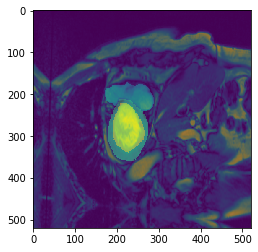

In [4]:
c, img, mask = dataset[70]
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

In [5]:
test_dataset = ACDCDataset('../data/acdc/testing/testing', None, augmentation, preload=False, load_mask=False)

In [6]:
len(test_dataset)

1076

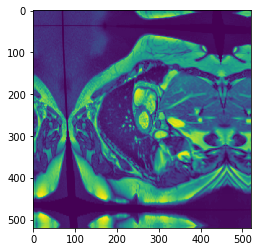

In [8]:
c, img, mask = test_dataset[20]
plt.imshow(img.numpy()[0])
plt.show()

In [6]:
img.max(), img.min()

(tensor(2.1699), tensor(-2.2222))

In [7]:
train_dataset, val_dataset = dataset.split_train_val(train_size=0.7)

In [8]:
len(train_dataset)

1328

In [9]:
len(val_dataset)

574

In [10]:
img = nibabel.Nifti1Image(np.vstack((mask.numpy(), mask.numpy())), np.eye(4))

In [ ]:
img.header.get_xyzt_units()

In [ ]:
img.to_filename('test2.nii.gz')

In [ ]:
!ls

In [ ]:
np.vstack((mask.numpy(), mask.numpy())).shape

In [4]:
mask_f = nibabel.load('../data/acdc/training/patient004/patient004_frame01_gt.nii.gz')

In [5]:
mask_f.to_filename('test3.nii.gz')

In [6]:
mask_f.get_fdata().dtype



dtype('float64')

In [ ]:
mask_f.affine

In [ ]:
print(mask_f.header)

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

net = torchvision.models.shufflenet_v2_x1_0(pretrained=False)
net.conv1[0] = torch.nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

backbone = torchvision.models._utils.IntermediateLayerGetter(net, return_layers={'conv5': 'out'})
classifier = torchvision.models.segmentation.fcn.FCNHead(1024, 4)
model = torchvision.models.segmentation.FCN(backbone, classifier).to(device)
model.load_state_dict(torch.load('/Users/airplaneless/source/projects/medsegmentation/models/fcn-shufflenetV2/fcn-shufflenetv2.pth', map_location=device))

<All keys matched successfully>

In [12]:
c, img, mask = dataset[37]

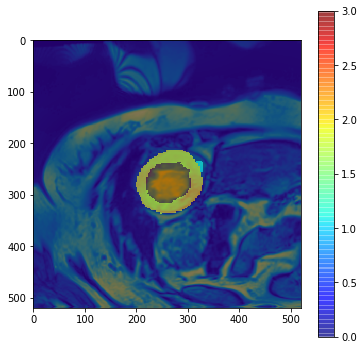

In [25]:
plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [14]:
model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))['out'][0]

In [15]:
probas = torch.nn.functional.softmax(pred, dim=0)

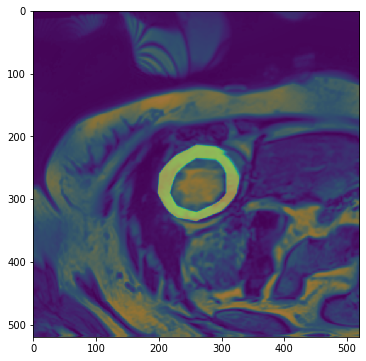

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(probas.cpu().numpy()[2], alpha=0.5)
plt.show()

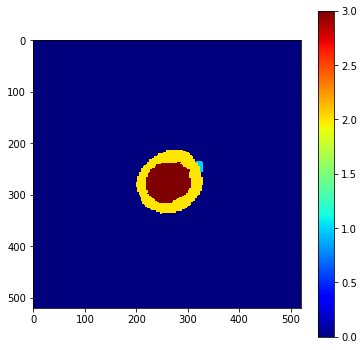

In [26]:
plt.figure(figsize=(6,6))
plt.imshow(mask.numpy()[0], cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [29]:
def prob2mask(arr):
    pred_mask = np.zeros((520, 520))
    for cat in range(1, arr.shape[0]):
        mask_cat = arr[cat]
        mask_cat[mask_cat > 0.5] = 1
        mask_cat[mask_cat <= 0.5] = 0
        pred_mask += mask_cat * cat
    return pred_mask

pred_mask = prob2mask(probas.cpu().numpy())

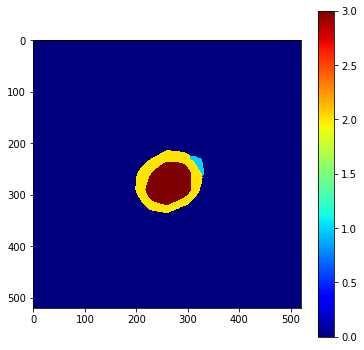

In [31]:
plt.figure(figsize=(6,6))
plt.imshow(pred_mask, cmap=plt.cm.jet)
plt.colorbar()
plt.show()